# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
%pylab inline 
import pickle 
import numpy as np
import cv2
from sklearn.utils import shuffle


Populating the interactive namespace from numpy and matplotlib


In [2]:
# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = shuffle(train['features'], train['labels'])
X_valid, y_valid = shuffle(valid['features'], valid['labels'])
X_test, y_test = test['features'], test['labels']

In [3]:
import random
import pandas as pd

signames = pd.read_csv('signnames.csv', index_col=0)['SignName']

### Visualizing dataset
taking random pictures

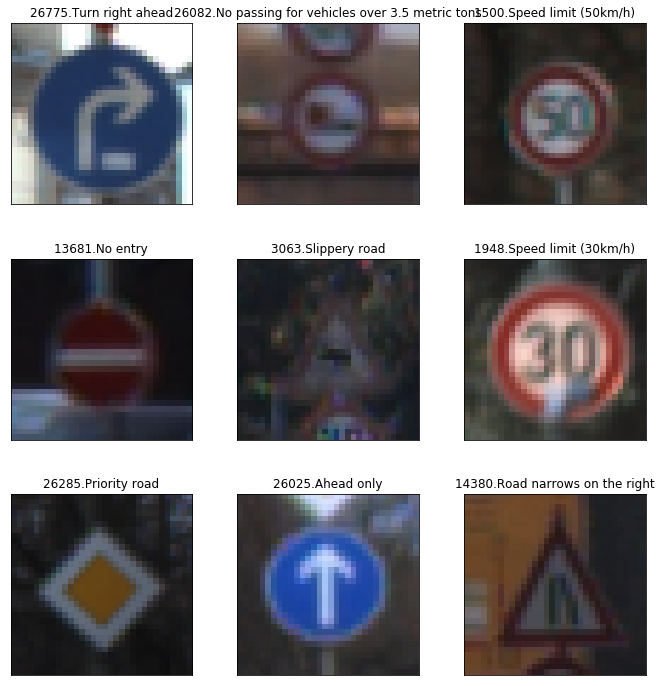

In [4]:
fig, axes = subplots(3, 3, figsize=(12, 12),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)


random_idx = random.sample(range(len(X_train)), 9)

for ax, i in zip(axes.flat, random_idx):
    ax.imshow(X_train[i])
    ax.set_title(str(i) +'.' + signames[y_train[i]])
show()

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

In [5]:
from scipy.misc import imresize

In [6]:
s_train = train['sizes']
c_train = train['coords']

(32, 32, 3)
(41, 40, 3)
Wild animals crossing


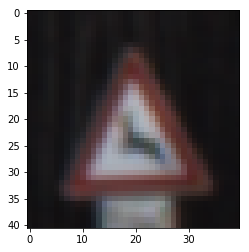

In [7]:
img_n = randint(0, len(X_train))
oimg = X_train[img_n].copy()
img = imresize(oimg.copy(), s_train[img_n])

imshow(img)
print(oimg.shape)
print(img.shape)
print(signames[y_train[img_n]])

### Trying to see what can give the other information in the data set

[ 5  5 36 34]


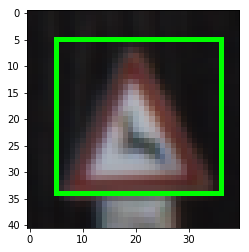

In [8]:
img = cv2.rectangle(img, tuple(c_train[img_n][:2]), tuple(c_train[img_n][2:]), [0,255,0], 1)

imshow(img)
print(c_train[img_n])

I don't really see, how I can use this boundry...

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [9]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = y_train.shape[0]

# TODO: Number of validation examples
n_validation = y_valid.shape[0]

# TODO: Number of testing examples.
n_test = y_test.shape[0]
n_valid = y_valid.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.max(y_train)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_valid)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 42


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [10]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
import bisect
from skimage import data, img_as_float, img_as_ubyte
from skimage import exposure
from sklearn.preprocessing import LabelBinarizer

In [11]:
def normalize_picture(pic):
    ret = pic.astype(np.float32) * 1.0/255.
    return ret - 0.5

### Imadjust 
Implementation is taken from http://stackoverflow.com/a/31650693/1586200 and adapted to python

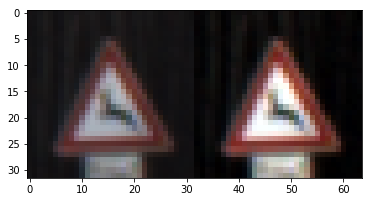

In [12]:
def imadjust_1(src, dst, tol=1, vin=[0,255], vout=(0,255)):
    # src : input one-layer image
    # tol : tolerance, from 0 to 100.
    # vin  : src image bounds
    # vout : dst image buonds
    # return : output img

    tol = max(0, min(100, tol))
    
    if tol > 0:
        # Compute in and out limits
        # Histogram
        hist = np.zeros(256, dtype=np.int)
        for r in range(src.shape[0]):
            for c in range(src.shape[1]):
                hist[src[r,c]] += 1
        # Cumulative histogram
        cum = hist.copy()
        for i in range(1, len(hist)):
            cum[i] = cum[i - 1] + hist[i]

        # Compute bounds
        total = src.shape[0] * src.shape[1]
        low_bound = total * tol / 100
        upp_bound = total * (100 - tol) / 100
        vin[0] = bisect.bisect_left(cum, low_bound)
        vin[1] = bisect.bisect_left(cum, upp_bound)

    # Stretching
    scale = (vout[1] - vout[0]) / (vin[1] - vin[0])
    for r in range(dst.shape[0]):
        for c in range(dst.shape[1]):
            vs = max(src[r,c] - vin[0], 0)
            vd = min(int(vs * scale + 0.5) + vout[0], vout[1])
            dst[r,c] = vd
    return dst

def imadjust(src, tol=1, vin=[0,255], vout=(0,255)):
    dst = np.zeros(src.shape, dtype=np.ubyte)
    #dst = src.copy()
    for i in range(src.shape[2]):
        imadjust_1(src[:,:,i], dst[:,:,i], tol, vin, vout)
    return dst

## example
dst = imadjust(oimg)
imshow(np.hstack((oimg, dst)))

### HSV Histogram equalization

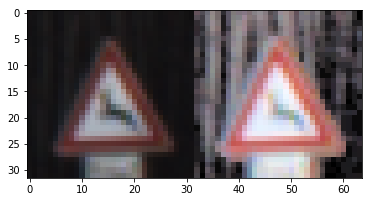

In [13]:
def equalizeHistHSV(src):
    dst = src.copy()
    dst = cv2.cvtColor(dst, cv2.COLOR_RGB2HSV)
    for i in range(2, dst.shape[2]):
        dst[:,:,i] = cv2.equalizeHist(dst[:,:,i])
    dst = cv2.cvtColor(dst, cv2.COLOR_HSV2RGB)
    return dst


dst = equalizeHistHSV(oimg)
imshow(np.hstack((oimg, dst)))

### Adapthist_eq
Contrast Limited Adaptive Histogram Equalization (CLAHE).

An algorithm for local contrast enhancement, that uses histograms computed over different tile regions of the image. Local details can therefore be enhanced even in regions that are darker or lighter than most of the image.

In [14]:
import warnings
warnings.filterwarnings('ignore')

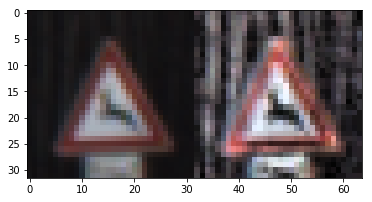

In [15]:
def adapthisteq(src):
    img = img_as_float(src)
    dst = exposure.equalize_adapthist(img, clip_limit=0.03)
    dst = img_as_ubyte(dst)
    return dst

imshow(np.hstack((oimg, adapthisteq(oimg))))

(32, 128, 3)


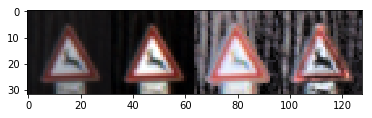

In [16]:
def preprocess_picture(src):
    dst = np.hstack((src, imadjust(src), equalizeHistHSV(src), adapthisteq(src))) #2.6s
    #dst = np.hstack((src, src, equalizeHistHSV(src), adapthisteq(src))) #0.99s
    #dst = np.hstack((src, imadjust(src), equalizeHistHSV(src))) #1.46s
    #dst = np.hstack((src, imadjust(src), src, adapthisteq(src))) #2.34s
    return dst

prep_img = preprocess_picture(oimg)
imshow(prep_img)
print(prep_img.shape)

For some pictures one method works better than the other one, so I decided to combine them together

In [17]:
def prepare_set(src):
    """
    preprocess the whole data_set images
    src.shape = (?, 32, 128, 3)
    """
    dst = np.zeros((src.shape[0], *prep_img.shape), dtype=np.ubyte)
    for i in range(src.shape[0]):
        dst[i] = preprocess_picture(src[i])
    dst = normalize_picture(dst)
    return dst

In [18]:
from time import time
from winsound import Beep

In [ ]:
# just curious how much time it takes to preprocess
start = time()
tmp_set = prepare_set(X_test[:100])
elasp = time() - start
print(elasp)

## Preprocessing all the data first

In [ ]:
start = time()
XP_test = prepare_set(X_test)
XP_valid = prepare_set(X_valid)
XP_train = prepare_set(X_train)


label_binarizer = LabelBinarizer()
y_one_hot_train = label_binarizer.fit_transform(y_train)
y_one_hot_valid = label_binarizer.fit_transform(y_valid)
y_one_hot_test = label_binarizer.fit_transform(y_test)

print(time() - start)
Beep(2500, 1000)

In [ ]:
np.save('XP_test.npy', XP_test)
np.save('XP_valid.npy', XP_valid)
np.save('XP_train.npy', XP_train)
np.save('y_one_hot_test.npy', y_one_hot_test)
np.save('y_one_hot_valid.npy', y_one_hot_valid)
np.save('y_one_hot_train.npy', y_one_hot_train)

## checkpoint

In [19]:
# checkpoint
XP_test = np.load('XP_test.npy')
XP_train = np.load('XP_train.npy')
XP_valid = np.load('XP_valid.npy')

y_one_hot_train = np.load('y_one_hot_train.npy')
y_one_hot_valid = np.load('y_one_hot_valid.npy')
y_one_hot_test = np.load('y_one_hot_test.npy')

### Model Architecture

Inspired by [Multi-column Deep Neural Networks for Image Classification](https://arxiv.org/abs/1202.2745)

I found out, that not using original (not preprocessed) picture didn't affect on the loss and accuracy, but it did affect on the training time by 10s on my machine for one epoch


![model layout](DNNstructure.png "Layout")

In [20]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

from keras.models import Model
from keras.layers import Cropping2D, Input, Conv2D, MaxPooling2D, Dense, Flatten, concatenate, Dropout
from keras import initializers
from keras.callbacks import LearningRateScheduler, EarlyStopping

Using TensorFlow backend.


In [39]:
def Dnn(in_layer):
    winit = initializers.TruncatedNormal(stddev=0.05)
    # 32x32x3
    conv = Conv2D(32, (3,3), padding='same', kernel_initializer=winit, activation='relu')(in_layer)
    
    #conv = Conv2D(48, (3,3), padding='same', kernel_initializer=winit, activation='relu')(conv)
    # 32x32x48
    pool = MaxPooling2D((2,2))(conv)
    # 16x16x32
    conv = Conv2D(64, (3,3), padding='valid', kernel_initializer=winit, activation='relu')(pool)
    drop = Dropout(0.5)(conv)
    # 14x14x64
    pool = MaxPooling2D((2,2))(drop)
    # 7x7x64
    conv = Conv2D(128, (3,3), padding='valid', kernel_initializer=winit, activation='relu')(pool)
    # 5x5x128
    flat = Flatten()(conv)
    dense1 = Dense(256,activation='relu', kernel_initializer=winit)(flat)
    
    return dense1

In [40]:
def build_model():
    w = image_shape[1]
    h = image_shape[0]
    winit = initializers.TruncatedNormal(stddev=0.05)
    
    input_img = Input(shape=prep_img.shape)
    
    img_num = int(prep_img.shape[1] / w)
    dnn_list = []
    #for i in range(1,img_num): # from 1, so the original img is skipped 
    #for i in range(1, 2):
    i = 0
    p = Cropping2D(cropping=((0,0), (i*w,w*(img_num-i-1))))(input_img)
    dnn = Dnn(p)
    #dnn_list.append(d)

    #dnn = concatenate(dnn_list, axis=1)
    dense2 = Dense(1024,activation='relu', kernel_initializer=winit)(dnn)
    output_layer = Dense(43,activation='softmax')(dense2)
        
    model = Model(inputs=input_img, outputs=output_layer)
    return model

In [43]:
model = build_model()
model.compile('adam', 'categorical_crossentropy', ['accuracy'])

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [44]:
history = model.fit(XP_train, y_one_hot_train, 
                    epochs=50, verbose=2, batch_size=128,
                    validation_data=(XP_valid, y_one_hot_valid),
                    callbacks=[#LearningRateScheduler(lr_schedule),
                        EarlyStopping(monitor='loss', patience=5, verbose=0, min_delta=1e-03)])

Train on 34799 samples, validate on 4410 samples
Epoch 1/50
12s - loss: 1.1324 - acc: 0.6681 - val_loss: 0.5044 - val_acc: 0.8923
Epoch 2/50
12s - loss: 0.1876 - acc: 0.9427 - val_loss: 0.4050 - val_acc: 0.8871
Epoch 3/50
12s - loss: 0.0982 - acc: 0.9706 - val_loss: 0.2260 - val_acc: 0.9333
Epoch 4/50
12s - loss: 0.0709 - acc: 0.9786 - val_loss: 0.2267 - val_acc: 0.9372
Epoch 5/50
12s - loss: 0.0521 - acc: 0.9839 - val_loss: 0.2364 - val_acc: 0.9367
Epoch 6/50
12s - loss: 0.0415 - acc: 0.9870 - val_loss: 0.2558 - val_acc: 0.9240
Epoch 7/50
12s - loss: 0.0372 - acc: 0.9877 - val_loss: 0.1891 - val_acc: 0.9494
Epoch 8/50
12s - loss: 0.0264 - acc: 0.9919 - val_loss: 0.2188 - val_acc: 0.9372
Epoch 9/50
12s - loss: 0.0322 - acc: 0.9894 - val_loss: 0.2475 - val_acc: 0.9451
Epoch 10/50
12s - loss: 0.0290 - acc: 0.9912 - val_loss: 0.2432 - val_acc: 0.9474
Epoch 11/50
12s - loss: 0.0276 - acc: 0.9914 - val_loss: 0.3076 - val_acc: 0.9254
Epoch 12/50
12s - loss: 0.0238 - acc: 0.9928 - val_loss: 0

In [ ]:
Beep(2500, 1000)

In [ ]:
model.save('dnn4.h5')

In [25]:
model.evaluate(XP_test, y_one_hot_test)

12630/12630 [==============================] - 4s     


[0.23200323516143498, 0.94908946953590012]

Not the best accuracy, comparing to the [results](http://benchmark.ini.rub.de/?section=gtsrb&subsection=results#), but I expected worse.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

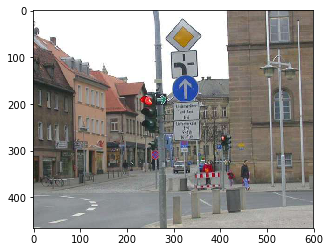

In [26]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

from urllib.request import urlretrieve
url = 'http://cdn.trendhunterstatic.com/thumbs/germany-traffic.jpeg'

urlretrieve(url, 'gt.jpg')

img = imread('gt.jpg')
imshow(img)

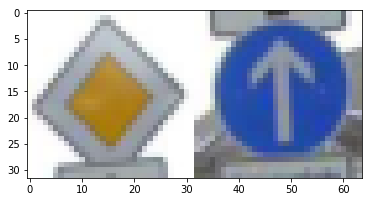

In [27]:
google_images = [imresize(img[15:95, 280:366], (32,32))]
google_images.append(imresize(img[135:205, 290:360], (32,32)))
imshow(np.hstack(google_images))

In [28]:
import os

In [29]:
# pictures are taken from the googlemaps service
dir_name = 'gmaps'
for filename in os.listdir(dir_name):
    img = imread(dir_name+'/'+filename)
    img = imresize(img, (32,32))
    google_images.append(img)
print(len(google_images))

13


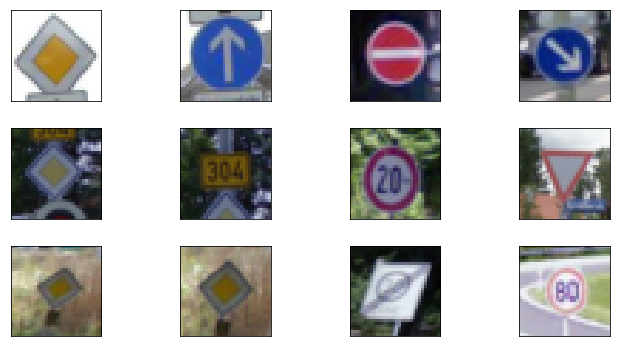

In [30]:
fig, axes = subplots(3, 4, figsize=(12, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)

for ax, img in zip(axes.flat, google_images):
    ax.imshow(img)
show()

### Predict the Sign Type for Each Image

In [31]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
X_i = prepare_set(np.array(google_images))
prediction = model.predict(X_i)

In [32]:
len(google_images)

13

In [33]:
# decoding sign number into sign name
def decode_sign(pred):
    top_5_args = np.argsort(pred)[-5:][::-1]
    top_5_prob = [pred[x] for x in top_5_args]
    top_5_label = [signames[x] for x in top_5_args]
    for sign in top_5_args:
            print("{:2} ({:.4}%): {}".format(sign, pred[sign]*100, signames[sign]))

In [34]:
Y_pred = [np.argsort(x)[-1] for x in prediction]

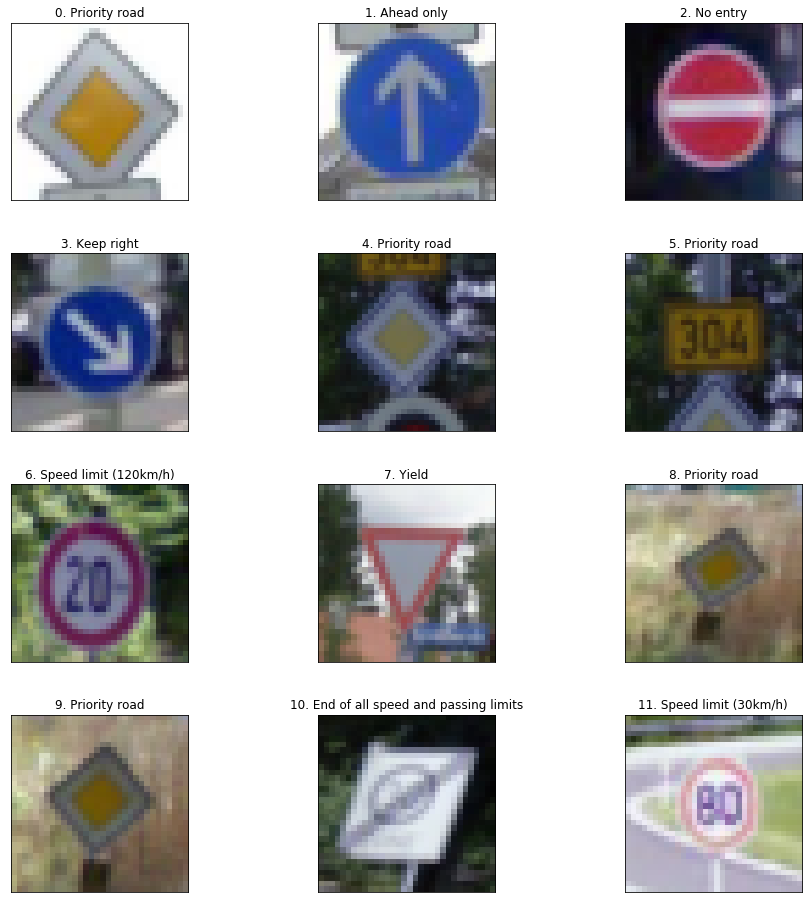

In [35]:
fig, axes = subplots(4, 3, figsize=(16, 16),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.1)

for i, (ax, img) in enumerate(zip(axes.flat, google_images)):
    ax.imshow(img)
    ax.set_title(str(i)+'. '+ signames[Y_pred[i]])
show()

### Let's look closer at the sign 6

 8 (45.66%): Speed limit (120km/h)
 1 (17.83%): Speed limit (30km/h)
24 (12.46%): Road narrows on the right
 7 (7.155%): Speed limit (100km/h)
 4 (6.49%): Speed limit (70km/h)


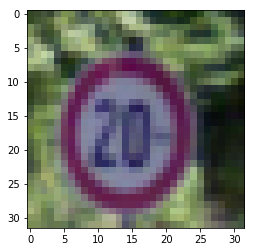

In [36]:
decode_sign(prediction[6])
imshow(google_images[6])

Interesting example, Speed limit 20 not even in the top-5

In [37]:
print(signames[0], ": train set has", np.count_nonzero(y_train == 0), " entries")
print(signames[1], ": train set has", np.count_nonzero(y_train == 1), " entries")
print(signames[7], ": train set has", np.count_nonzero(y_train == 7), " entries")

Speed limit (20km/h) : train set has 180  entries
Speed limit (30km/h) : train set has 1980  entries
Speed limit (100km/h) : train set has 1290  entries


Ok, 180 examples against 1290, probably that's why it didn't even guess

### Analyze Performance

### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
It wont be fair to count number 10 as a mistake, because the dataset simply doesn't have this sign, and my model guessed it pretty close.
Interesting that the picture number 5 is recognised as priority road, of course the model doesn't know about this sign, but it managed to recodnise the half of the priority sign. Which I don't like, but I suppose it's a task of finding and marking signs on the big picture.

Ignoring the two signs, described above, I can say that we have 1 mistake for 10 pictures, which is 90% accurate

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [38]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
for i, pred in enumerate(prediction):
    print("\nPicture N", i)
    decode_sign(pred)


Picture N 0
12 (100.0%): Priority road
14 (1.138e-09%): Stop
29 (7.957e-11%): Bicycles crossing
17 (6.782e-11%): No entry
42 (3.391e-11%): End of no passing by vehicles over 3.5 metric tons

Picture N 1
35 (100.0%): Ahead only
28 (2.467e-11%): Children crossing
 9 (8.218e-12%): No passing
 5 (5.011e-12%): Speed limit (80km/h)
13 (3.764e-12%): Yield

Picture N 2
17 (100.0%): No entry
14 (0.0001108%): Stop
29 (4.782e-06%): Bicycles crossing
26 (6.952e-07%): Traffic signals
 0 (5.913e-08%): Speed limit (20km/h)

Picture N 3
38 (100.0%): Keep right
36 (3.081e-16%): Go straight or right
23 (1.348e-19%): Slippery road
34 (1.345e-21%): Turn left ahead
25 (4.794e-22%): Road work

Picture N 4
12 (99.99%): Priority road
13 (0.004966%): Yield
35 (3.128e-05%): Ahead only
26 (2.668e-05%): Traffic signals
 1 (1.324e-05%): Speed limit (30km/h)

Picture N 5
12 (100.0%): Priority road
13 (0.001055%): Yield
14 (0.0004687%): Stop
 9 (0.0001108%): No passing
 5 (3.777e-05%): Speed limit (80km/h)

Picture

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")